# Multi-Layer Perception, MNIST (with validation)
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) handwritten digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
>2. Define a neural network
>3. Train the model
>4. Evaluate the performance of our trained model on a test dataset

Before we begin, we have to import the necessary libraries for working with data and PyTorch.



In [1]:
# import libraries
import torch
import numpy as np

## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

You may choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percetnage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, 
                            transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True,
                           transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
  sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
  sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
  num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

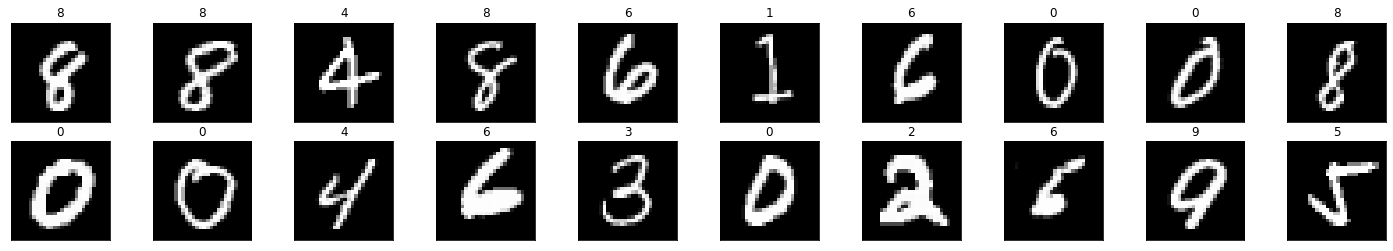

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # print out the correct label for each image
  # .item() gets the value contained in a Tensor
  ax.set_title(str(labels[idx].item()))

### View and Image in More Detail

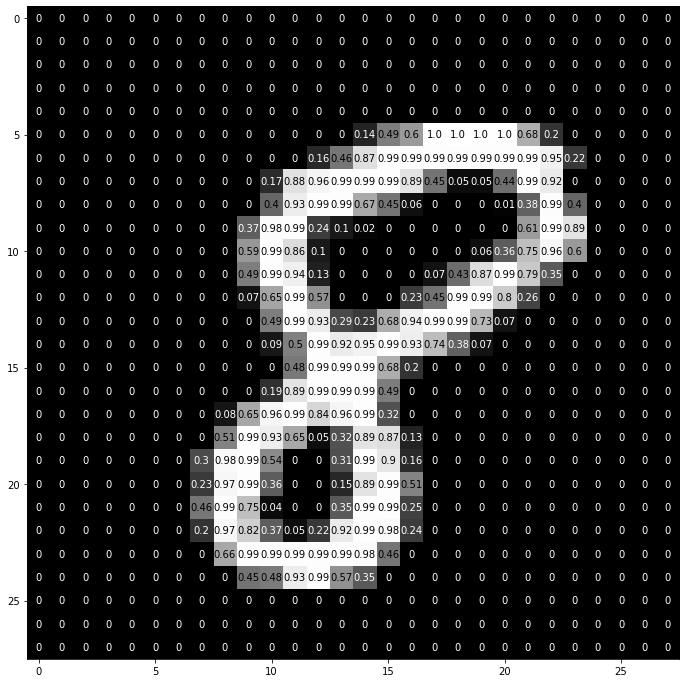

In [13]:
img = np.squeeze(images[1])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
  for y in range(height):
    val = round(img[x][y], 2) if img[x][y] != 0 else 0
    ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center',
                color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dimension Tensor of pixel values for each image and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # Number of hidden nodes in each layer (512)
    hidden_1 = 512
    hidden_2 = 512
    # linear layer (784 -> hidden_1)
    self.fc1 = nn.Linear(784, hidden_1)
    # linear layer (hidden_1 -> hidden_2)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    # linear layer (hidden_2 -> 10 output nodes)
    self.fc3 = nn.Linear(hidden_2, 10)
    # dropout layer with probability=0.2
    self.dropout = nn.Dropout(p=0.2)
    
  def forward(self, x):
    # flatten image input
    x = x.view(-1, 784)
    # Pass through first linear, ReLU, and dropout layers
    x = self.dropout(F.relu(self.fc1(x)))
    # Pass through second linear, ReLU, and dropout layers
    x = self.dropout(F.relu(self.fc2(x)))
    # Pass through third linear layer
    x = self.fc3(x)
    return x

# Initialize the neural network
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It is recommended to use cross-entropy loss for classification. PyTorch's cross entropy function applies a softmax function to the output layer *and* then calculates the log-loss.

In [21]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate=0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step
6. Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  model.train() # prep model for training
  for data, target in train_loader:
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to the model
    # parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    train_loss += loss.item()*data.size(0)

  ######################
  # validate the model #
  ######################
  model.eval() # prep model for evaluation
  for data, target in valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update running validation loss
    valid_loss += loss.item()*data.size(0)

  # print training/validation statistics